In [210]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score
from xgboost import XGBClassifier, plot_tree, plot_importance

def seed_everything(seed:int=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

warnings.filterwarnings('ignore')
seed_everything()

In [170]:
df = pd.read_csv('./dataset/ff.csv')

def make_targets(targets):
    return 1 if targets >=5 else 0

df['BE3_31'] = df.apply(
    lambda row: make_targets(row['BE3_31']), axis=1
)
df['BE5_1'] = df.apply(
    lambda row: make_targets(row['BE5_1']), axis=1
)

df.head(3)

,HE_FEV1FVC,age,Total_slp_wk,sex,occp,EC1_1,cfam,marri_1,BH9_11,HE_DM,...,EC_pedu_1,EC_pedu_2,BS5_1,BD7_4,eq_5d,sm_present,mh_stress,cage,BE3_31,BE5_1
0,0.699366,74.0,8.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,NaN,NaN,비흡연자,없었음,0.720,1,1.0,7,1,0
1,0.698630,80.0,6.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,...,NaN,NaN,비흡연자,없었음,0.723,0,0.0,7,0,0
2,0.698466,49.0,8.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,...,무학,무학,언젠가금연,1년동안있었음,1.000,0,0.0,4,0,0


In [171]:
drops = df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100
display(drops)
df = df[drops[drops.values <= 10].index]

HE_cough1       23.867550
HE_sput1        23.867550
EC_pedu_1       23.682119
EC_pedu_2       20.503311
HE_DM           16.529801
BD7_4           15.072848
BD7_5           13.086093
BH9_11          11.735099
BP6_10          10.728477
BP5             10.622517
BH1             10.490066
BS5_1            4.582781
occp             1.748344
EC1_1            1.589404
edu              1.589404
LQ4_00           1.509934
LQ_4EQL          1.483444
LQ1_sb           1.456954
BH2_61           1.456954
LQ1_mn           1.456954
LQ_5EQL          1.456954
LQ_3EQL          1.456954
LQ_1EQL          1.456954
LQ_2EQL          1.456954
MO1_wk           1.430464
D_1_1            1.377483
BS6_3            0.158940
BS6_2_1          0.158940
marri_1          0.132450
BP1              0.105960
BS3_1            0.105960
mh_stress        0.105960
BO1_1            0.079470
cfam             0.079470
BO2_1            0.052980
BD1              0.026490
sm_present       0.000000
cage             0.000000
BE3_31      

In [172]:
# 1차년도
NUMERIC = ['HE_FEV1FVC', 'age', 'Total_slp_wk']
CATEGORICAL = ['sex', 'occp', 'EC1_1', 'cfam', 'marri_1', 'BH9_11', 'HE_DM', 'DC6_dg', 'DF2_dg', 'HE_HPdg', 'BP5']
ONE_HOT = ['BS3_1', 'edu', 'BP1', 'D_1_1', 'LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL', 'LQ_4EQL', 'LQ_5EQL', 'BO1_1', 'BO2_1']
# 2차년도
NUMERIC2 = ['DI1_ag', 'DE1_ag', 'LQ1_mn', 'BS6_2_1', 'BS6_3']
CATEGORICAL2 = ['DI1_pt', 'DE1_pt', 'DE1_3', 'BH1', 'BH2_61', 'LQ4_00', 'LQ4_05', 'LQ1_sb', 'MO1_wk', 'HE_cough1', 'HE_sput1', 'BD1', 'BD7_5', 'BP6_10', 'BP6_31']
ONE_HOT2 = ['DI1_2', 'EC_pedu_1', 'EC_pedu_2', 'BS5_1', 'BD7_4']
# 생성변수
NUMERIC3 = ['eq_5d']
CATEGORICAL3 = ['sm_present', 'mh_stress']
ONE_HOT3 = ['cage']
# Targets
TARGETS = ['BE3_31', 'BE5_1']

f_NUMERIC = (NUMERIC + NUMERIC2 + NUMERIC3).copy()
f_CATEGORICAL = (CATEGORICAL + CATEGORICAL2 + CATEGORICAL3).copy()
f_ONE_HOT = (ONE_HOT + ONE_HOT2 + ONE_HOT3).copy()

In [175]:
for value in f_NUMERIC:
    if value not in df.columns:
        print(value)
        f_NUMERIC.remove(value)

In [179]:
for value in f_CATEGORICAL:
    if value not in df.columns:
        print(value)
        f_CATEGORICAL.remove(value)

In [182]:
for value in f_ONE_HOT:
    if value not in df.columns:
        print(value)
        f_ONE_HOT.remove(value)

In [183]:
df.isna().sum().sort_values(ascending=False)

BS5_1           173
occp             66
EC1_1            60
edu              60
LQ4_00           57
LQ_4EQL          56
LQ_3EQL          55
LQ_2EQL          55
LQ_1EQL          55
LQ1_mn           55
LQ_5EQL          55
BH2_61           55
LQ1_sb           55
MO1_wk           54
D_1_1            52
BS6_3             6
BS6_2_1           6
marri_1           5
BP1               4
mh_stress         4
BS3_1             4
BO1_1             3
cfam              3
BO2_1             2
BD1               1
age               0
Total_slp_wk      0
sex               0
HE_HPdg           0
cage              0
HE_FEV1FVC        0
eq_5d             0
BE3_31            0
sm_present        0
BE5_1             0
dtype: int64

In [187]:
for col in df.columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [194]:
X = df.drop('BE5_1', axis=1)
y = df['BE5_1']

X_numeric = X[f_NUMERIC]
X_categorical = X[f_CATEGORICAL]
X_onehot = X[f_ONE_HOT]

In [199]:
X_onehot = pd.get_dummies(X_onehot, dtype=float)
X_onehot_cage = pd.get_dummies(X_onehot['cage'], dtype='float')
X_onehot.drop('cage', axis=1, inplace=True)
X_onehot = pd.concat([X_onehot, X_onehot_cage], axis=1)

In [201]:
X = pd.concat([X_numeric, X_categorical], axis=1)
X = pd.concat([X, X_onehot], axis=1)

In [202]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

train_X = train_X.reset_index().drop('index', axis=1)
train_y = train_y.reset_index().drop('index', axis=1)

In [205]:
param_2 = {
    'n_estimators': 276, 
    'max_depth': 66, 
    'learning_rate': 0.009816392225839262, 
    'gamma': 9.709392373191752, 
    'alpha': 0.852347089015269, 
    'lambda': 9.832382625248556, 
    'min_child_weight': 5.9361686080930305, 
    'max_delta_step': 26, 
    'subsample': 0.5658032101992756, 
    'sampling_method': 'uniform', 
    'tree_method': 'approx', 
    'grow_policy': 'depthwise', 
    'max_bin': 282, 
    'scale_pos_weight': 8.09638554
}
model2 = XGBClassifier(objective='binary:logistic', device='cuda', random_state=42, **param_2)
model2.fit(train_X, train_y)

XGBClassifier(alpha=0.852347089015269, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=9.709392373191752, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              lambda=9.832382625248556, learning_rate=0.009816392225839262,
              max_bin=282, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=26, max_depth=66, max_leaves=None,
              min_child_weight=5.9361686080930305, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=276,
              n_jobs=None, ...)

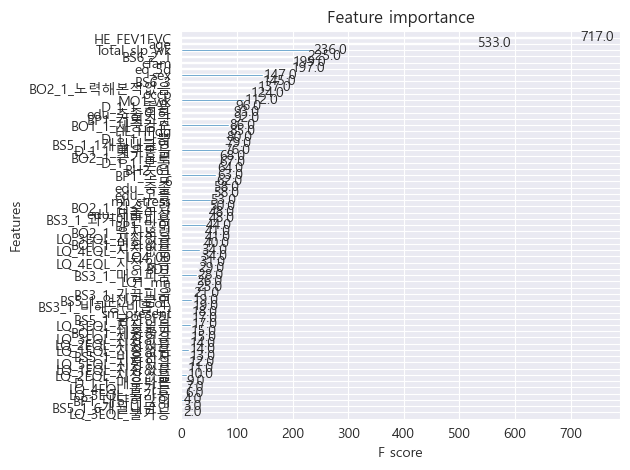

In [217]:
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.figure(figsize=(20, 20))
plot_importance(model2)
# fig = plt.gcf()
# fig.set_size_inches(200, 150)
plt.tight_layout()
plt.show()

In [208]:
print(classification_report(train_y, model2.predict(train_X)))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      2688
           1       0.31      0.82      0.45       332

    accuracy                           0.78      3020
   macro avg       0.64      0.80      0.65      3020
weighted avg       0.90      0.78      0.81      3020


In [207]:
print(classification_report(test_y, model2.predict(test_X)))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84       672
           1       0.24      0.61      0.35        83

    accuracy                           0.75       755
   macro avg       0.59      0.69      0.60       755
weighted avg       0.86      0.75      0.79       755


In [101]:
ratio = float(np.sum(train_y == 0)) / np.sum(train_y == 1)
ratio.values[0]

8.096385542168674

In [50]:
def objective(trial:optuna.Trial, xdata, ydata):
    scores = []
    
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
        'max_depth' : trial.suggest_int('max_depth', 5, 100),
        'learning_rate' : trial.suggest_float('learning_rate', .0001, .01),
        'gamma' : trial.suggest_float('gamma', 0, 10),
        'alpha' : trial.suggest_float('alpha', 0, 1),
        'lambda' : trial.suggest_float('lambda', 1, 10),
        'min_child_weight' : trial.suggest_float('min_child_weight', 0, 10),
        'max_delta_step' : trial.suggest_int('max_delta_step', 0, 30),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'sampling_method' : trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based']),
        'tree_method' : trial.suggest_categorical('tree_method', ['hist', 'approx']),
        'grow_policy' : trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'max_bin' : trial.suggest_int('max_bin', 256, 512)
    }
    kf = StratifiedKFold(n_splits=5)
    for train_idx, val_idx in kf.split(xdata, ydata):
        standard = StandardScaler()
        onehot = OneHotEncoder(handle_unknown='ignore')

        preprocessor = ColumnTransformer(
            transformers=[
                ('numeric', standard, f_NUMERIC),
                ('onehot', onehot, f_ONE_HOT)
            ]
        )
        
        tr_X = xdata.loc[train_idx]
        tr_X = preprocessor.fit_transform(tr_X)
        tr_y = ydata.loc[train_idx]
        
        val_X = xdata.loc[val_idx]
        val_X = preprocessor.transform(val_X)
        val_y = ydata.loc[val_idx]
        
        ratio = float(np.sum(tr_y == 0)) / np.sum(tr_y == 1)
        model = XGBClassifier(objective='binary:logistic', scale_pos_weight=ratio.values[0], device='cuda', random_state=42, **param)
        
    
        model.fit(tr_X, tr_y, verbose=False, eval_metric='error', eval_set=[(tr_X, tr_y),(val_X, val_y)])
        
        pred = model.predict(val_X)
        scores.append(f1_score(pred, val_y))
        
    return np.mean(scores)

In [51]:
study = optuna.create_study(direction='maximize')

study.optimize(lambda trial:objective(trial, train_X, train_y), n_trials=500)
print(f'Best trial: {study.best_trial}')
print(f'Best value: {study.best_value}')
print(f'Best params: {study.best_params}')

[I 2023-12-26 14:00:44,126] A new study created in memory with name: no-name-e2da7e6c-1ece-4a29-8ad7-3621627891c1
[I 2023-12-26 14:01:01,493] Trial 0 finished with value: 0.2630069032119286 and parameters: {'n_estimators': 224, 'max_depth': 73, 'learning_rate': 0.007740390659122578, 'gamma': 4.086875039868679, 'alpha': 0.31498501771842713, 'lambda': 3.2268761986367425, 'min_child_weight': 6.577334976476727, 'max_delta_step': 20, 'subsample': 0.5958540011415534, 'sampling_method': 'uniform', 'tree_method': 'approx', 'grow_policy': 'depthwise', 'max_bin': 429}. Best is trial 0 with value: 0.2630069032119286.
[I 2023-12-26 14:01:12,712] Trial 1 finished with value: 0.2638769092385915 and parameters: {'n_estimators': 124, 'max_depth': 9, 'learning_rate': 0.003426088596987653, 'gamma': 4.232404744566307, 'alpha': 0.45426396016122794, 'lambda': 6.5477142890680575, 'min_child_weight': 0.1328903069643983, 'max_delta_step': 7, 'subsample': 0.6950196348522049, 'sampling_method': 'uniform', 'tree

Best trial: FrozenTrial(number=369, state=1, values=[0.3014400392494814], datetime_start=datetime.datetime(2023, 12, 26, 15, 25, 11, 826358), datetime_complete=datetime.datetime(2023, 12, 26, 15, 25, 21, 81713), params={'n_estimators': 284, 'max_depth': 11, 'learning_rate': 0.008195214092087604, 'gamma': 9.147028215583385, 'alpha': 0.7217150203616696, 'lambda': 9.287813758942903, 'min_child_weight': 6.229774788878522, 'max_delta_step': 9, 'subsample': 0.5720119795496469, 'sampling_method': 'uniform', 'tree_method': 'hist', 'grow_policy': 'lossguide', 'max_bin': 478}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=100, log=False, low=5, step=1), 'learning_rate': FloatDistribution(high=0.01, log=False, low=0.0001, step=None), 'gamma': FloatDistribution(high=10.0, log=False, low=0.0, step=None), 'alpha': FloatDistribution(high=1.0, log=False, low=0.0, step=None

In [56]:
def objective(trial:optuna.Trial, xdata, ydata):
    scores = []
    
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
        'max_depth' : trial.suggest_int('max_depth', 5, 100),
        'learning_rate' : trial.suggest_float('learning_rate', .0001, .01),
        'gamma' : trial.suggest_float('gamma', 0, 10),
        'alpha' : trial.suggest_float('alpha', 0, 1),
        'lambda' : trial.suggest_float('lambda', 1, 10),
        'min_child_weight' : trial.suggest_float('min_child_weight', 0, 10),
        'max_delta_step' : trial.suggest_int('max_delta_step', 0, 30),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'sampling_method' : trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based']),
        'tree_method' : trial.suggest_categorical('tree_method', ['hist', 'approx']),
        'grow_policy' : trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'max_bin' : trial.suggest_int('max_bin', 256, 512),
        'scale_pos_weight' : trial.suggest_categorical('scale_pos_weight', [1, 8.09638554])
    }
    kf = StratifiedKFold(n_splits=5)
    for train_idx, val_idx in kf.split(xdata, ydata):
        standard = StandardScaler()
        onehot = OneHotEncoder(handle_unknown='ignore')

        preprocessor = ColumnTransformer(
            transformers=[
                ('numeric', standard, f_NUMERIC),
                ('onehot', onehot, f_ONE_HOT)
            ]
        )
        
        tr_X = xdata.loc[train_idx]
        tr_X = preprocessor.fit_transform(tr_X)
        tr_y = ydata.loc[train_idx]
        
        val_X = xdata.loc[val_idx]
        val_X = preprocessor.transform(val_X)
        val_y = ydata.loc[val_idx]
        
        ratio = float(np.sum(tr_y == 0)) / np.sum(tr_y == 1)
        model = XGBClassifier(objective='binary:logistic', device='cuda', random_state=42, **param)
        
    
        model.fit(tr_X, tr_y, verbose=False, eval_metric='error', eval_set=[(tr_X, tr_y),(val_X, val_y)])
        
        pred = model.predict(val_X)
        scores.append(f1_score(pred, val_y))
        
    return np.mean(scores)

In [57]:
study = optuna.create_study(direction='maximize')

study.optimize(lambda trial:objective(trial, train_X, train_y), n_trials=500)
print(f'Best trial: {study.best_trial}')
print(f'Best value: {study.best_value}')
print(f'Best params: {study.best_params}')

[I 2023-12-27 01:22:46,629] A new study created in memory with name: no-name-611e403e-b899-40c8-82f8-e39267f24415
[I 2023-12-27 01:23:01,415] Trial 0 finished with value: 0.26722723215824773 and parameters: {'n_estimators': 183, 'max_depth': 49, 'learning_rate': 0.004823070096336469, 'gamma': 4.5123097920501865, 'alpha': 0.8559668559135061, 'lambda': 4.627916609955008, 'min_child_weight': 6.978490268107724, 'max_delta_step': 15, 'subsample': 0.577191425026705, 'sampling_method': 'gradient_based', 'tree_method': 'approx', 'grow_policy': 'depthwise', 'max_bin': 426, 'scale_pos_weight': 8.09638554}. Best is trial 0 with value: 0.26722723215824773.
[I 2023-12-27 01:23:35,529] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 475, 'max_depth': 76, 'learning_rate': 0.008446208941193096, 'gamma': 1.9798067623010096, 'alpha': 0.6455186520675956, 'lambda': 6.0794322209204825, 'min_child_weight': 0.6687314433398228, 'max_delta_step': 28, 'subsample': 0.8048113016794819, 'sampling

Best trial: FrozenTrial(number=347, state=1, values=[0.30283296446471464], datetime_start=datetime.datetime(2023, 12, 27, 3, 2, 40, 921942), datetime_complete=datetime.datetime(2023, 12, 27, 3, 2, 58, 925317), params={'n_estimators': 276, 'max_depth': 66, 'learning_rate': 0.009816392225839262, 'gamma': 9.709392373191752, 'alpha': 0.852347089015269, 'lambda': 9.832382625248556, 'min_child_weight': 5.9361686080930305, 'max_delta_step': 26, 'subsample': 0.5658032101992756, 'sampling_method': 'uniform', 'tree_method': 'approx', 'grow_policy': 'depthwise', 'max_bin': 282, 'scale_pos_weight': 8.09638554}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=100, log=False, low=5, step=1), 'learning_rate': FloatDistribution(high=0.01, log=False, low=0.0001, step=None), 'gamma': FloatDistribution(high=10.0, log=False, low=0.0, step=None), 'alpha': FloatDistribution(high=1

In [102]:
param_1 = {
    'n_estimators': 284, 
    'max_depth': 11, 
    'learning_rate': 0.008195214092087604, 
    'gamma': 9.147028215583385, 
    'alpha': 0.7217150203616696, 
    'lambda': 9.287813758942903, 
    'min_child_weight': 6.229774788878522, 
    'max_delta_step': 9, 
    'subsample': 0.5720119795496469, 
    'sampling_method': 'uniform', 
    'tree_method': 'hist', 
    'grow_policy': 'lossguide', 
    'max_bin': 478,
    'scale_pos_weight': 8.09638554
}
model1 = XGBClassifier(objective='binary:logistic', device='cuda', random_state=42, **param_1)
param_2 = {
    'n_estimators': 276, 
    'max_depth': 66, 
    'learning_rate': 0.009816392225839262, 
    'gamma': 9.709392373191752, 
    'alpha': 0.852347089015269, 
    'lambda': 9.832382625248556, 
    'min_child_weight': 5.9361686080930305, 
    'max_delta_step': 26, 
    'subsample': 0.5658032101992756, 
    'sampling_method': 'uniform', 
    'tree_method': 'approx', 
    'grow_policy': 'depthwise', 
    'max_bin': 282, 
    'scale_pos_weight': 8.09638554
}
model2 = XGBClassifier(objective='binary:logistic', device='cuda', random_state=42, **param_2)

In [103]:
standard = StandardScaler()
onehot = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', standard, f_NUMERIC),
        ('onehot', onehot, f_ONE_HOT)        
    ]
)
tr_scaled_X = preprocessor.fit_transform(train_X)
te_scaled_X = preprocessor.transform(test_X)
model1.fit(tr_scaled_X, train_y)
model2.fit(tr_scaled_X, train_y)

XGBClassifier(alpha=0.852347089015269, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=9.709392373191752, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              lambda=9.832382625248556, learning_rate=0.009816392225839262,
              max_bin=282, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=26, max_depth=66, max_leaves=None,
              min_child_weight=5.9361686080930305, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=276,
              n_jobs=None, ...)

In [115]:
pred1 = model1.predict(tr_scaled_X)
pred2 = model2.predict(tr_scaled_X)

In [116]:
print(classification_report(train_y, pred1))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      2688
           1       0.30      0.80      0.44       332

    accuracy                           0.77      3020
   macro avg       0.64      0.79      0.65      3020
weighted avg       0.90      0.77      0.81      3020


In [117]:
print(classification_report(train_y, pred2))

              precision    recall  f1-score   support

           0       0.97      0.76      0.85      2688
           1       0.29      0.80      0.43       332

    accuracy                           0.76      3020
   macro avg       0.63      0.78      0.64      3020
weighted avg       0.89      0.76      0.81      3020


In [104]:
pred1 = model1.predict(te_scaled_X)
pred2 = model2.predict(te_scaled_X)

In [105]:
print(classification_report(test_y, pred1))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84       672
           1       0.23      0.57      0.32        83

    accuracy                           0.74       755
   macro avg       0.58      0.66      0.58       755
weighted avg       0.86      0.74      0.78       755


In [106]:
print(classification_report(test_y, pred2))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84       672
           1       0.23      0.58      0.33        83

    accuracy                           0.74       755
   macro avg       0.58      0.67      0.59       755
weighted avg       0.86      0.74      0.78       755


In [ ]:
plot_tree(model2, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(200, 150)
plt.show()

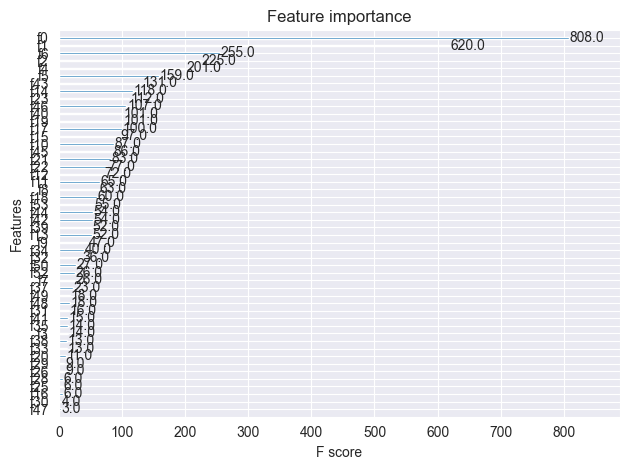

In [120]:
from xgboost import plot_importance
plot_importance(model2)
plt.tight_layout()

In [121]:
train_X[f_NUMERIC]

,HE_FEV1FVC,age,Total_slp_wk,LQ1_mn,BS6_2_1,BS6_3,eq_5d
0,0.657025,76.0,6.0,0.0,0.0,0.0,1.000
1,0.675718,42.0,6.0,0.0,0.0,0.0,1.000
2,0.666893,59.0,5.0,0.0,0.0,0.0,1.000
3,0.696323,61.0,8.0,0.0,30.0,20.0,0.950
4,0.637450,51.0,4.0,0.0,0.0,0.0,1.000
...,...,...,...,...,...,...,...
3015,0.671077,55.0,8.0,0.0,24.0,12.0,0.907
3016,0.583047,55.0,8.0,1.0,0.0,0.0,0.870
3017,0.672993,73.0,8.0,0.0,0.0,0.0,0.749
3018,0.675799,66.0,5.0,0.0,0.0,0.0,0.723


In [114]:
1/(1+ np.exp(-1 * 0.007))

0.5017499928542016

In [ ]:
param_1 = {
    'n_estimators': 284, 
    'max_depth': 11, 
    'learning_rate': 0.008195214092087604, 
    'gamma': 9.147028215583385, 
    'alpha': 0.7217150203616696, 
    'lambda': 9.287813758942903, 
    'min_child_weight': 6.229774788878522, 
    'max_delta_step': 9, 
    'subsample': 0.6, 
    'sampling_method': 'uniform', 
    'tree_method': 'approx', 
    'grow_policy': 'depthwise', 
    'max_bin': 478
}
model1 = XGBClassifier(objective='binary:logistic', device='cuda', random_state=42, **param_1)
param_2 = {
    'n_estimators': 276, 
    'max_depth': 66, 
    'learning_rate': 0.009816392225839262, 
    'gamma': 9.709392373191752, 
    'alpha': 0.852347089015269, 
    'lambda': 9.832382625248556, 
    'min_child_weight': 5.9361686080930305, 
    'max_delta_step': 26, 
    'subsample': 0.5658032101992756, 
    'sampling_method': 'uniform', 
    'tree_method': 'approx', 
    'grow_policy': 'depthwise', 
    'max_bin': 282, 
    'scale_pos_weight': 8.09638554
}
model2 = XGBClassifier(objective='binary:logistic', device='cuda', random_state=42, **param_2)